##  Handwriting Recognition Using CNN (3-Class Classification)

**Student:** _Nidhi Sreevathsava_  
**Programme:** M.Sc. in Statistics and Data Science  

**Platform:** Python (TensorFlow + Keras)  
**Image Format:** RGB (3-channel), Resized to 300x300

**Objective:** Develop and evaluate a CNN model to classify handwriting samples from three individuals

---

### What This Notebook Covers:

- Standardizing real-world handwriting images (variable sizes) into uniform 300x300×3 RGB
- Splitting dataset using a **90:10 train-test** ratio, stratified by person
- Creating TensorFlow data pipelines with **augmentation** for training generalization
- Building and training a **CNN from scratch**, understanding convolution, filters, activation functions, and fully connected layers
- Visualizing and interpreting **metrics like accuracy, precision, recall, F1-score**, and **confusion matrix**
- Performing **prediction** on new/unseen handwriting samples
- Concluding with **critical evaluation and possible improvements**

---


## Step 1: Environment Check & Package Imports

This notebook targets **TensorFlow/Keras**, **scikit-learn**, **Pillow/OpenCV**, **Matplotlib**, and **NumPy**.



In [11]:

# If you are running this in a fresh environment, uncomment the line below to install required libraries
# %pip install tensorflow scikit-learn matplotlib pillow opencv-python pandas

import sys, platform
print("🧾 Python version:", sys.version)
print("🖥️ Platform:", platform.platform())

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("📦 TensorFlow version:", tf.__version__)

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


🧾 Python version: 3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)]
🖥️ Platform: Windows-10-10.0.19045-SP0
📦 TensorFlow version: 2.20.0


## Step 2: Define Data Paths, Image Settings and Class Labels


```
data_raw/
├── person1/
│   ├── img001.jpg
│   ├── img002.png
│   └── ...
├── person2/
│   ├── ...
└── person3/
    ├── ...
```


We will **standardize** images to a new directory (`data_standardized`) so the raw data remains untouched.

```
data_standardized/
├── person1/
│   ├── img001.jpg
│   ├── img002.png
│   └── ...
├── person2/
│   ├── ...
└── person3/
    ├── ...
```

In [12]:

from pathlib import Path
import os

# Constants for image processing
IMG_HEIGHT, IMG_WIDTH = 300, 300
CHANNELS = 3
BATCH_SIZE = 8
EPOCHS = 75

# Data directories
data_root = Path("data_raw")  # Each subfolder inside contains images for one person
standardized_root = Path("data_standardized")
standardized_root.mkdir(parents=True, exist_ok=True)

# Extract class labels from folder names
class_names = sorted([folder.name for folder in data_root.iterdir() if folder.is_dir()])
print("📂 Classes detected:", class_names)


📂 Classes detected: ['person1', 'person2', 'person3']


## Step 3: Image Preprocessing — Resize to 300x300 RGB


- Ensures **consistent input** to the CNN regardless of original resolution.
- Keeps **3 channels (RGB)**. If an image is grayscale, we **convert** it to RGB (replicated channels).
- Saves standardized copies in `data_standardized/<class>/...`.

In [13]:

from PIL import Image

def standardize_image(input_path, output_path, size=(IMG_WIDTH, IMG_HEIGHT)):
    img = Image.open(input_path).convert('RGB')
    img = img.resize(size)
    img.save(output_path)

# Apply resizing to all images per class
for class_name in class_names:
    input_dir = data_root / class_name
    output_dir = standardized_root / class_name
    output_dir.mkdir(parents=True, exist_ok=True)
    for img_path in input_dir.glob("*.*"):
        standardize_image(img_path, output_dir / img_path.name)
print("✅ All images resized and standardized.")


✅ All images resized and standardized.


## Step 4: Construct DataFrame and Train-Test Split
Given 34 examples per person (class), we target ~**30 train** and **4 test** images per class.  
We build a manifest and split **within each class** for balance.


In [14]:

data = []
for label_index, class_name in enumerate(class_names):
    for path in (standardized_root / class_name).glob("*.*"):
        data.append((str(path), class_name, label_index))

df = pd.DataFrame(data, columns=["filepath", "label", "label_idx"])
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=SEED)

print("✅ Train samples:", len(train_df))
print("✅ Test samples:", len(test_df))

print("Train size:", len(train_df), " Test size:", len(test_df))
# Group counts to verify class balance
print("\nTrain class counts:\n", train_df['label'].value_counts())
print("\nTest class counts:\n", test_df['label'].value_counts())



✅ Train samples: 91
✅ Test samples: 11
Train size: 91  Test size: 11

Train class counts:
 label
person1    31
person2    30
person3    30
Name: count, dtype: int64

Test class counts:
 label
person2    4
person3    4
person1    3
Name: count, dtype: int64


## 🔄 Step 5: TensorFlow Data Pipeline + Augmentation

- Load 300x300×3 images from file paths.
- **Normalize** pixel values to `[0, 1]`.
- Apply **data augmentation** on-the-fly for training only (random flips/rotations/zoom/contrast).
- Batch and prefetch for efficiency.

In [16]:

AUTOTUNE = tf.data.AUTOTUNE
N_CLASSES = len(class_names)

# Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="data_augmentation")

# Function to load image from path and convert to tensor
def load_image(path, label_idx):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.one_hot(label_idx, N_CLASSES)

def create_dataset(dataframe, augment=False, shuffle=True):
    paths = dataframe["filepath"].values
    labels = dataframe["label_idx"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(dataframe), seed=SEED)
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = create_dataset(train_df, augment=True)
test_ds = create_dataset(test_df, augment=False, shuffle=False)

print(train_ds)

print(test_ds)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


##  Step 6: CNN Architecture Explanation


### Convolutional Neural Network (CNN) — Key Concepts

- **Convolution Layer:** Applies a set of filters (kernels) that extract spatial features like edges, curves, strokes.
- **Pooling Layer:** Downsamples features using max or average pooling to reduce computation and preserve patterns.
- **Dropout:** Prevents overfitting by randomly disabling neurons during training.
- **Dense Layer (FC):** Fully connected layer to interpret extracted features and output class probabilities.

###  Our CNN Architecture

| Layer Type        | Description                          |
|-------------------|--------------------------------------|
| Conv2D + ReLU     | 32 filters, 3×3 kernel               |
| MaxPooling2D      | Downsampling by 2                    |
| Conv2D + ReLU     | 64 filters                           |
| MaxPooling2D      | Downsampling                         |
| Conv2D + ReLU     | 128 filters                          |
| GlobalAvgPooling  | Converts feature map to single vector |
| Dropout           | p = 0.3 to prevent overfitting       |
| Dense (64) + ReLU | Intermediate representation          |
| Dense (3) + Softmax| Final classification output         |



Given the tiny dataset, we implement a compact CNN with:
- Convs + BatchNorm + ReLU
- MaxPooling
- Dropout & L2 regularization
  

> **Why not heavy transfer learning?**  
> Here we could have used transfer learning (e.g., EfficientNet). However, with fixed 224x224 and such a tiny dataset, a small baseline is more stable for demonstration.
> See **Recommendations** for transfer-learning options.


In [17]:

from tensorflow.keras import layers, models

def build_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), num_classes=N_CLASSES):
    model = models.Sequential([
        layers.InputLayer(shape=input_shape),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


C:\Users\sreev\miniconda3\envs\ds\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 300, 300, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 150, 150, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 150, 150, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,699 (397.26 KB)

 Trainable params: 101,699 (397.26 KB)

 Non-trainable params: 0 (0.00 B)

## Step 7: Training the CNN Model

This step fits the model to your training data using the fit() function from Keras. During training, the CNN learns to extract and recognize features from the 
handwriting images that help it distinguish between the three individuals.

The training loop performs the following actions for each epoch:

- Forward pass:
The input image goes through the layers of the CNN — convolution, pooling, dense — and produces a prediction.

- Loss computation:
The prediction is compared with the true label using categorical cross-entropy loss, since this is a multi-class classification problem.

- Backward pass (Backpropagation):
The loss is used to compute gradients, which adjust the filter weights in convolution layers and weights in dense layers to reduce future errors.

- Optimization:
The Adam optimizer updates weights based on gradients to minimize the loss function over time.


| Parameter                 | Description                                                      |
| ------------------------- | ---------------------------------------------------------------- |
| `train_ds`                | Preprocessed dataset with augmentation used to teach the model   |
| `validation_data=test_ds` | Assesses performance on unseen data after each epoch             |
| `epochs=EPOCHS`           | Number of full passes over the training data (set earlier to 50) |
| `callbacks`               | Special functions triggered during training (explained below)    |


#### Callbacks in Detail
- EarlyStopping

Goal: Avoid overfitting.

What it does: Monitors validation loss. If it doesn't improve for 10 consecutive epochs, it stops training early and restores the weights from the epoch with the best validation performance.

- ModelCheckpoint

Goal: Save the best model.

Saves the model to file whenever it achieves a better validation score than before.

#### After Training: 

A trained model that has learned distinct handwriting features.

A history object containing:

- training/validation loss

- training/validation accuracy

- useful for plotting learning curves.


#### Note on Number of EPochs and Early Stopping:
In deep learning models, the number of epochs completed during training may vary slightly on each run, even when using the same dataset, model architecture, and hyperparameters. This is primarily due to the inherent non-determinism in the training process.

Key reasons for this variation include:
•	- Random initialization of weights at the start of training.
•	- Shuffling of training data before each epoch.
•	- Non-deterministic operations on GPU hardware.
•	- Random behavior introduced by Dropout layers (if used).

As a result, the validation loss curve may vary slightly between runs, which can cause the EarlyStopping callback to trigger at different points. For example, one run may stop at epoch 29 while another may stop at epoch 35, depending on when the model sees no further improvement in validation loss for the specified patience window.




In [18]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=75,
                    callbacks=callbacks)


Epoch 1/75
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step - accuracy: 0.2967 - loss: 1.1146 - val_accuracy: 0.3636 - val_loss: 1.0936
Epoch 2/75
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - accuracy: 0.3077 - loss: 1.0994 - val_accuracy: 0.3636 - val_loss: 1.0944
Epoch 3/75
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.3407 - loss: 1.0906 - val_accuracy: 0.3636 - val_loss: 1.0898
Epoch 4/75
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.3297 - loss: 1.1159 - val_accuracy: 0.3636 - val_loss: 1.0860
Epoch 5/75
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.3626 - loss: 1.0933 - val_accuracy: 0.4545 - val_loss: 1.0941
Epoch 6/75
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.3516 - loss: 1.0959 - val_accuracy: 0.3636 - val_loss: 1.0925
Epoch 7/75
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.3956 - loss: 1.0864 - val_accuracy: 0.3636 - val_loss: 1.0849
Epoch 8/75
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.3626 - loss: 1.1004 - val_accuracy: 0.

## Step 8: Model Evaluation

To assess how well trained CNN performs on unseen handwriting images (i.e., the test set). This step helps understand the model’s strengths and weaknesses across all three classes — one for each person.

| Metric               | Meaning                                                                                     |
| -------------------- | ------------------------------------------------------------------------------------------- |
| **Accuracy**         | Proportion of total correct predictions. Overall performance.                               |
| **Precision**        | Of the predicted samples for a class, how many were correct?                                |
| **Recall**           | Of the actual samples of a class, how many were captured by the model?                      |
| **F1-score**         | Harmonic mean of precision and recall. Balance between false positives and false negatives. |
| **Support**          | Number of true instances per class in the test set.                                         |
| **Confusion Matrix** | Tells exactly how many times each class was confused with others.                           |


Why These Metrics Matter

- Precision is important if false positives are costly (e.g., mistaking one person’s handwriting for another).

- Recall is important when you must catch all instances of a class (e.g., detecting forensics handwriting).

- F1-score gives a balanced view when classes are imbalanced or when both precision and recall matter.


In [19]:

y_true, y_pred, y_probs = [], [], []

for imgs, labels in test_ds:
    preds = model.predict(imgs)
    y_probs.extend(preds)
    y_pred.extend(tf.argmax(preds, axis=1).numpy())
    y_true.extend(tf.argmax(labels, axis=1).numpy())

# Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Classification Report:
              precision    recall  f1-score   support

     person1       1.00      1.00      1.00         3
     person2       1.00      0.50      0.67         4
     person3       0.67      1.00      0.80         4

    accuracy                           0.82        11
   macro avg       0.89      0.83      0.82        11
weighted avg       0.88      0.82      0.81        11



## 📊 Step 9: Confusion Matrix & Interpretation

The confusion matrix provides a clear, visual breakdown of model’s predictions compared to the true labels.

It is a square matrix where:

- Rows represent the actual labels (ground truth)

- Columns represent the predicted labels

- Each cell [i, j] shows how many times class i was predicted as class j.

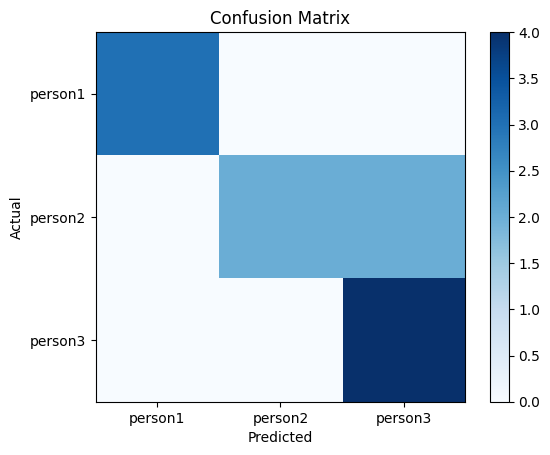

In [20]:

cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=range(N_CLASSES), labels=class_names)
plt.yticks(ticks=range(N_CLASSES), labels=class_names)
plt.colorbar()
plt.show()


## Step 10: Insight into Evaluation Metrics



| Class       | Precision | Recall | F1-Score | Support | Meaning                                                                                            |
| ----------- | --------- | ------ | -------- | ------- | -------------------------------------------------------------------------------------------------- |
| **person1** | 1.00      | 1.00   | 1.00     | 3       | Perfect classification: all 3 samples of `person1` were predicted correctly.                       |
| **person2** | 1.00      | 0.50   | 0.67     | 4       | 100% precision (no false positives), but only 50% recall (missed 2 actual samples).                |
| **person3** | 0.67      | 1.00   | 0.80     | 4       | Some false positives (lower precision), but all actual `person3` samples were correctly predicted. |


| Metric        | What it Measures                                                       | Insight                                                      |
| ------------- | ---------------------------------------------------------------------- | ------------------------------------------------------------ |
| **Precision** | Out of all predicted for a class, how many were actually correct?      | High for all classes → few false positives.                  |
| **Recall**    | Out of all actual samples of a class, how many did the model identify? | Lower for `person2` (only 50%) → some missed.                |
| **F1-Score**  | Harmonic mean of precision and recall                                  | Balances both — good indicator of per-class performance.     |
| **Support**   | Actual number of test samples in that class                            | Helps weigh the importance of each class in overall metrics. |


| Metric           | Value                                       | Explanation                                                     |
| ---------------- | ------------------------------------------- | --------------------------------------------------------------- |
| **Accuracy**     | 0.82                                        | 82% of all predictions were correct (9 out of 11).              |
| **Macro Avg**    | Precision: 0.89<br>Recall: 0.83<br>F1: 0.82 | Simple average across all classes (treats all equally).         |
| **Weighted Avg** | Precision: 0.88<br>Recall: 0.82<br>F1: 0.81 | Average weighted by support (more samples have more influence). |



## STEP 10: PREDICTING ON A NEW HANDWRITING IMAGE

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


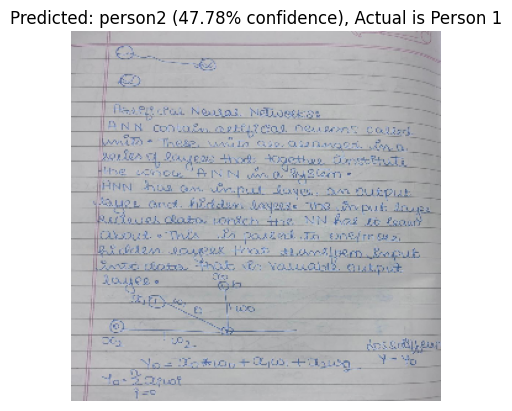

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


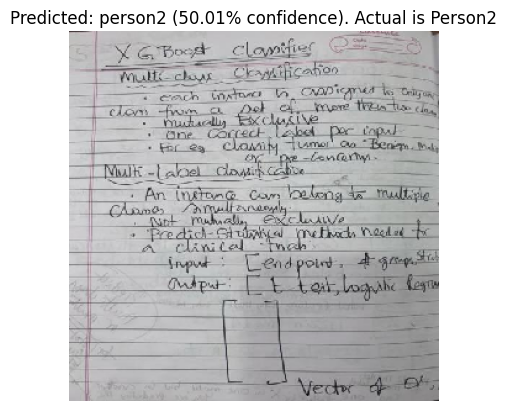

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


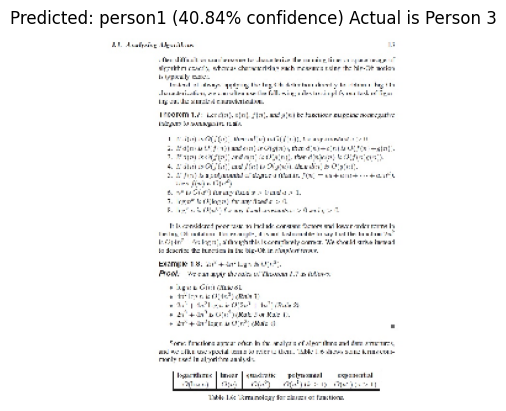

In [1]:
# STEP 10: PREDICTING ON A NEW HANDWRITING IMAGE

from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.models import load_model

# Load best-performing model
model = load_model("best_model.keras")

# Now use `model.predict()` etc., without retraining

class_names = ['person1', 'person2', 'person3']

# prediction for person1
# === Step 1: Load and preprocess image ===
img_path = "predict_hw1.jpg"  # example path
img = load_img(img_path, target_size=(300,300))     # Load image as PIL object
img_array = img_to_array(img) / 255.0                 # Convert to normalized array
img_array = np.expand_dims(img_array, axis=0)         # Add batch dimension

# === Step 2: Predict ===
pred = model.predict(img_array)
predicted_class = np.argmax(pred)
confidence = np.max(pred)

# === Step 3: Display result ===
plt.imshow(img)                                       # Now pass the PIL image (not path)
plt.axis('off')
plt.title(f"Predicted: {class_names[predicted_class]} ({confidence*100:.2f}% confidence), Actual is Person 1")
plt.show()

# Another prediction for person2
# === Step 1: Load and preprocess image ===
img_path = "predict_hw2.jpg"  # example path
img = load_img(img_path, target_size=(300,300))     # Load image as PIL object
img_array = img_to_array(img) / 255.0                 # Convert to normalized array
img_array = np.expand_dims(img_array, axis=0)         # Add batch dimension

# === Step 2: Predict ===
pred = model.predict(img_array)
predicted_class = np.argmax(pred)
confidence = np.max(pred)

# === Step 3: Display result ===
plt.imshow(img)                                       # Now pass the PIL image (not path)
plt.axis('off')
plt.title(f"Predicted: {class_names[predicted_class]} ({confidence*100:.2f}% confidence). Actual is Person2")
plt.show()

# prediction for person3
# === Step 1: Load and preprocess image ===
img_path = "predict_hw3_5.jpg"  # example path
img = load_img(img_path, target_size=(300,300))     # Load image as PIL object
img_array = img_to_array(img) / 255.0                 # Convert to normalized array
img_array = np.expand_dims(img_array, axis=0)         # Add batch dimension

# === Step 2: Predict ===
pred = model.predict(img_array)
predicted_class = np.argmax(pred)
confidence = np.max(pred)

# === Step 3: Display result ===
plt.imshow(img)                                       # Now pass the PIL image (not path)
plt.axis('off')
plt.title(f"Predicted: {class_names[predicted_class]} ({confidence*100:.2f}% confidence) Actual is Person 3")
plt.show()



###  Summary & Recommendations

- High overall performance (82% accuracy) despite small test size (11 samples).

- person2 has lower recall — the model misses some true samples from this class. You may need:

- More training samples for person2

- Better data augmentation

- Tune the model (e.g., layers, learning rate)

#### Suggestions to Improve

- Increase sample size, especially for underperforming classes.

- Fine-tune the model (e.g., more layers or filters).

- Use transfer learning (e.g., MobileNetV2) for better generalization.

- Adjust class weights if data is imbalanced.